In [37]:
import numpy as np
import pandas as pd
import os
import cv2
import copy
from glob import glob
from tqdm import tqdm

import SimpleITK as stk
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from skimage import measure

In [38]:
root = "/Users/STUFF/lungnode/subset0/"

In [39]:
def load_mhd(file):
    mhdimage = stk.ReadImage(root+file)
    ct_scan = stk.GetArrayFromImage(mhdimage)                
    origin = np.array(list(mhdimage.GetOrigin()))   
    space = np.array(list(mhdimage.GetSpacing()))   
    return ct_scan, origin, space

This function loads a medical CT scan (`.mhd` file) using `SimpleITK`, returning the scan array (`ct_scan`), origin, and spacing metadata for further analysis.

In [40]:
###### Test CT-Scans #######
test1 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd"
test2 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490.mhd"
test3 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd"
test4 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd"
test5 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd"
test6 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd"
test7 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490.mhd"
test8 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.mhd"
tests = [test1, test2, test3, test4, test5, test6, test7, test8]
layers = [69, 378, 82, 85, 85, 85, 85, 85]

In [41]:
for i,test in enumerate(tests):
    exec(f"ct{i+1}, origin{i+1}, space{i+1} = load_mhd(test)")

print("CT_SCAN SHAPE:",ct1.shape)
print("Origin:",origin1)
print("Space:",space1)
print("MAX:",ct1.max())
print("MIN:",ct2.min())

CT_SCAN SHAPE: (161, 512, 512)
Origin: [-187.699997 -108.300003 -194.      ]
Space: [0.54882801 0.54882801 1.25      ]
MAX: 2211
MIN: -3024


In [42]:
def display(imgs, layers=layers.copy(), titles=None, cmap="bone"):
    n = len(list(imgs))
    r = n//4 if n%4==0 else (n//4)+1
    plt.figure(figsize=(25,14))
    for i,img in enumerate(imgs):
        plt.subplot(r,4,i+1)
        if len(img.shape) == 3:
            if titles is not None:
                plt.title(titles[i])
            plt.imshow(img[layers[i]], cmap=cmap)
        else:
            if titles is not None:
                plt.title(titles[i])
            plt.imshow(img, cmap=cmap)

This function visualizes a list of medical images, supporting both 2D and 3D data. It displays slices of 3D images specified by `layers` and optionally adds titles to each subplot. Uses a customizable colormap (`bone` by default).

In [43]:
test_imgs = [ct1, ct2, ct3, ct4, ct5, ct6, ct7, ct8]

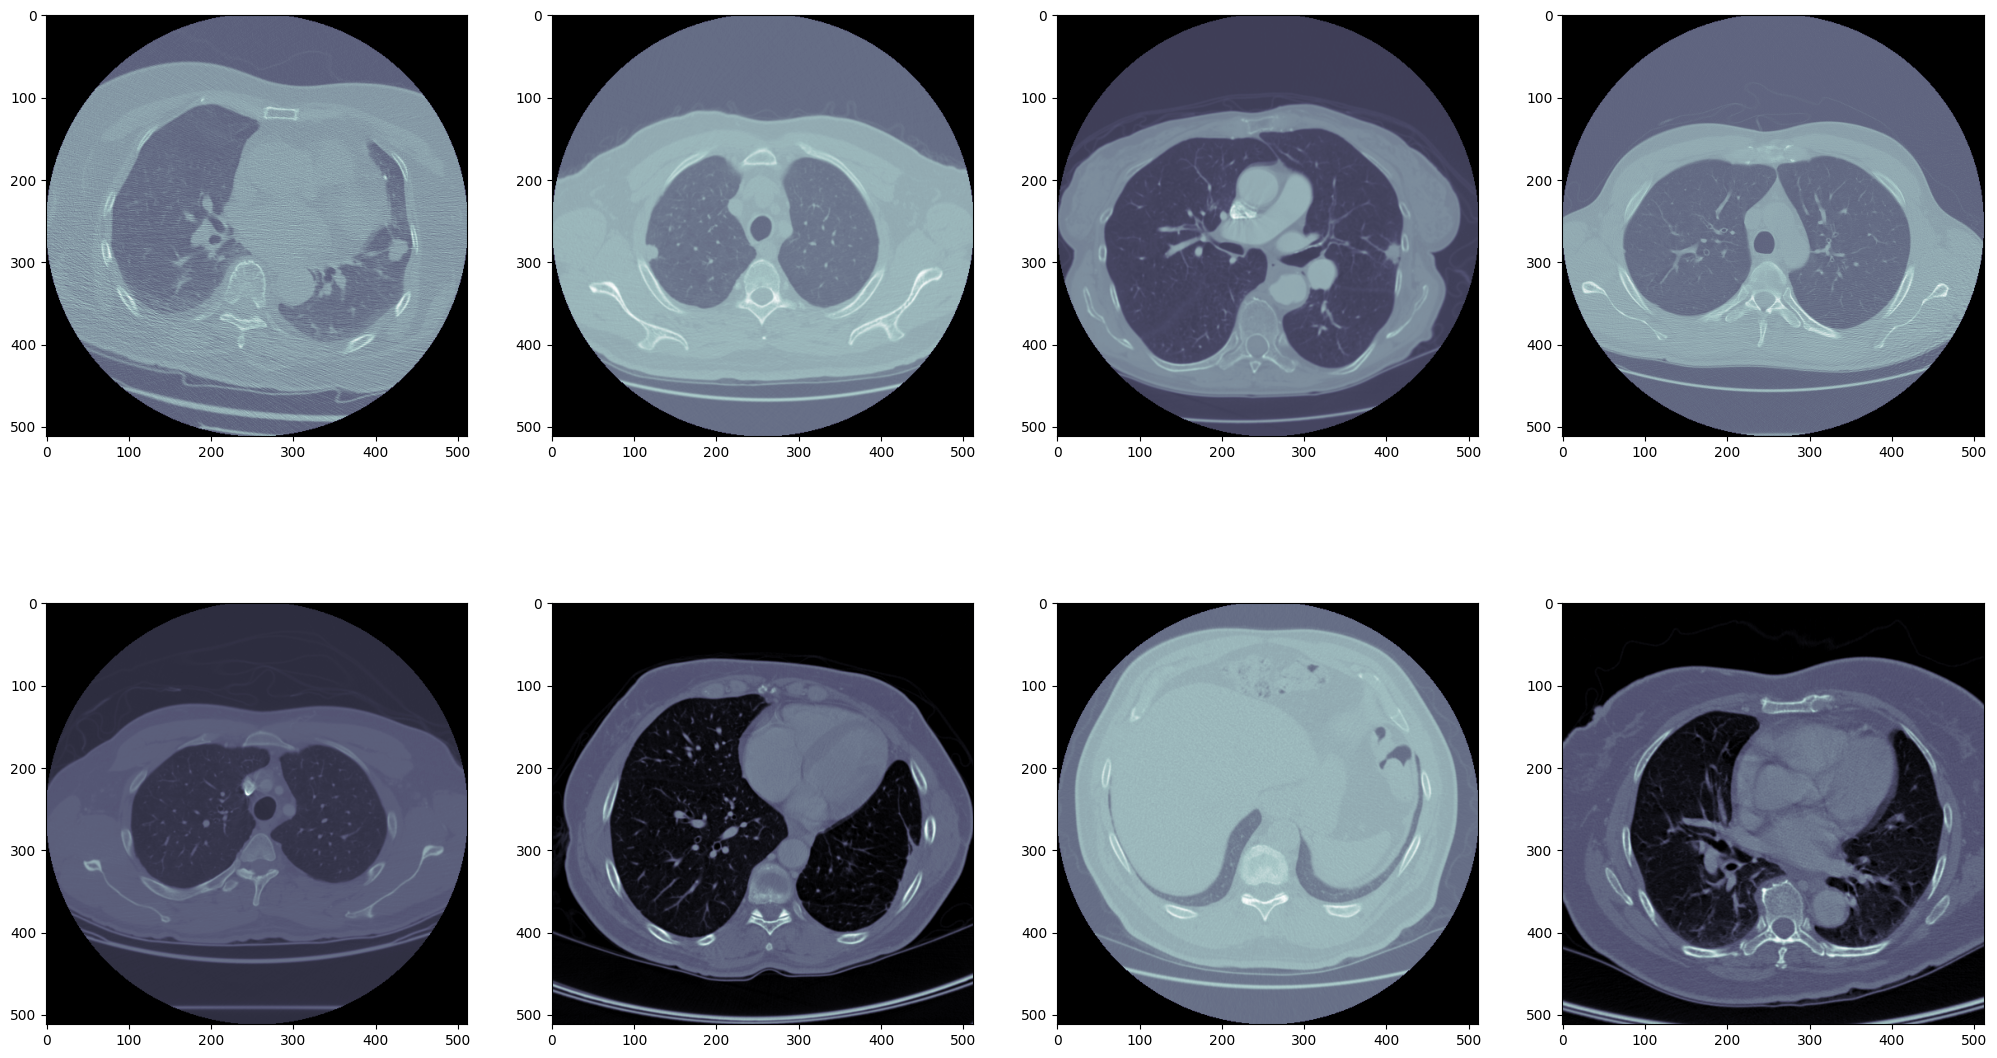

In [44]:
display(test_imgs)

In [45]:
norm_imgs = []
for ct in test_imgs:
    ig = cv2.normalize(ct, None, 0, 255, cv2.NORM_MINMAX)
    norm_imgs.append(ig)

print("MAX:",norm_imgs[1].max())
print("MIN:",norm_imgs[1].min())

MAX: 255
MIN: 0


This script normalizes a list of test images (`test_imgs`) to the range [0, 255] using OpenCV and prints the maximum and minimum pixel values of the second normalized image for verification.

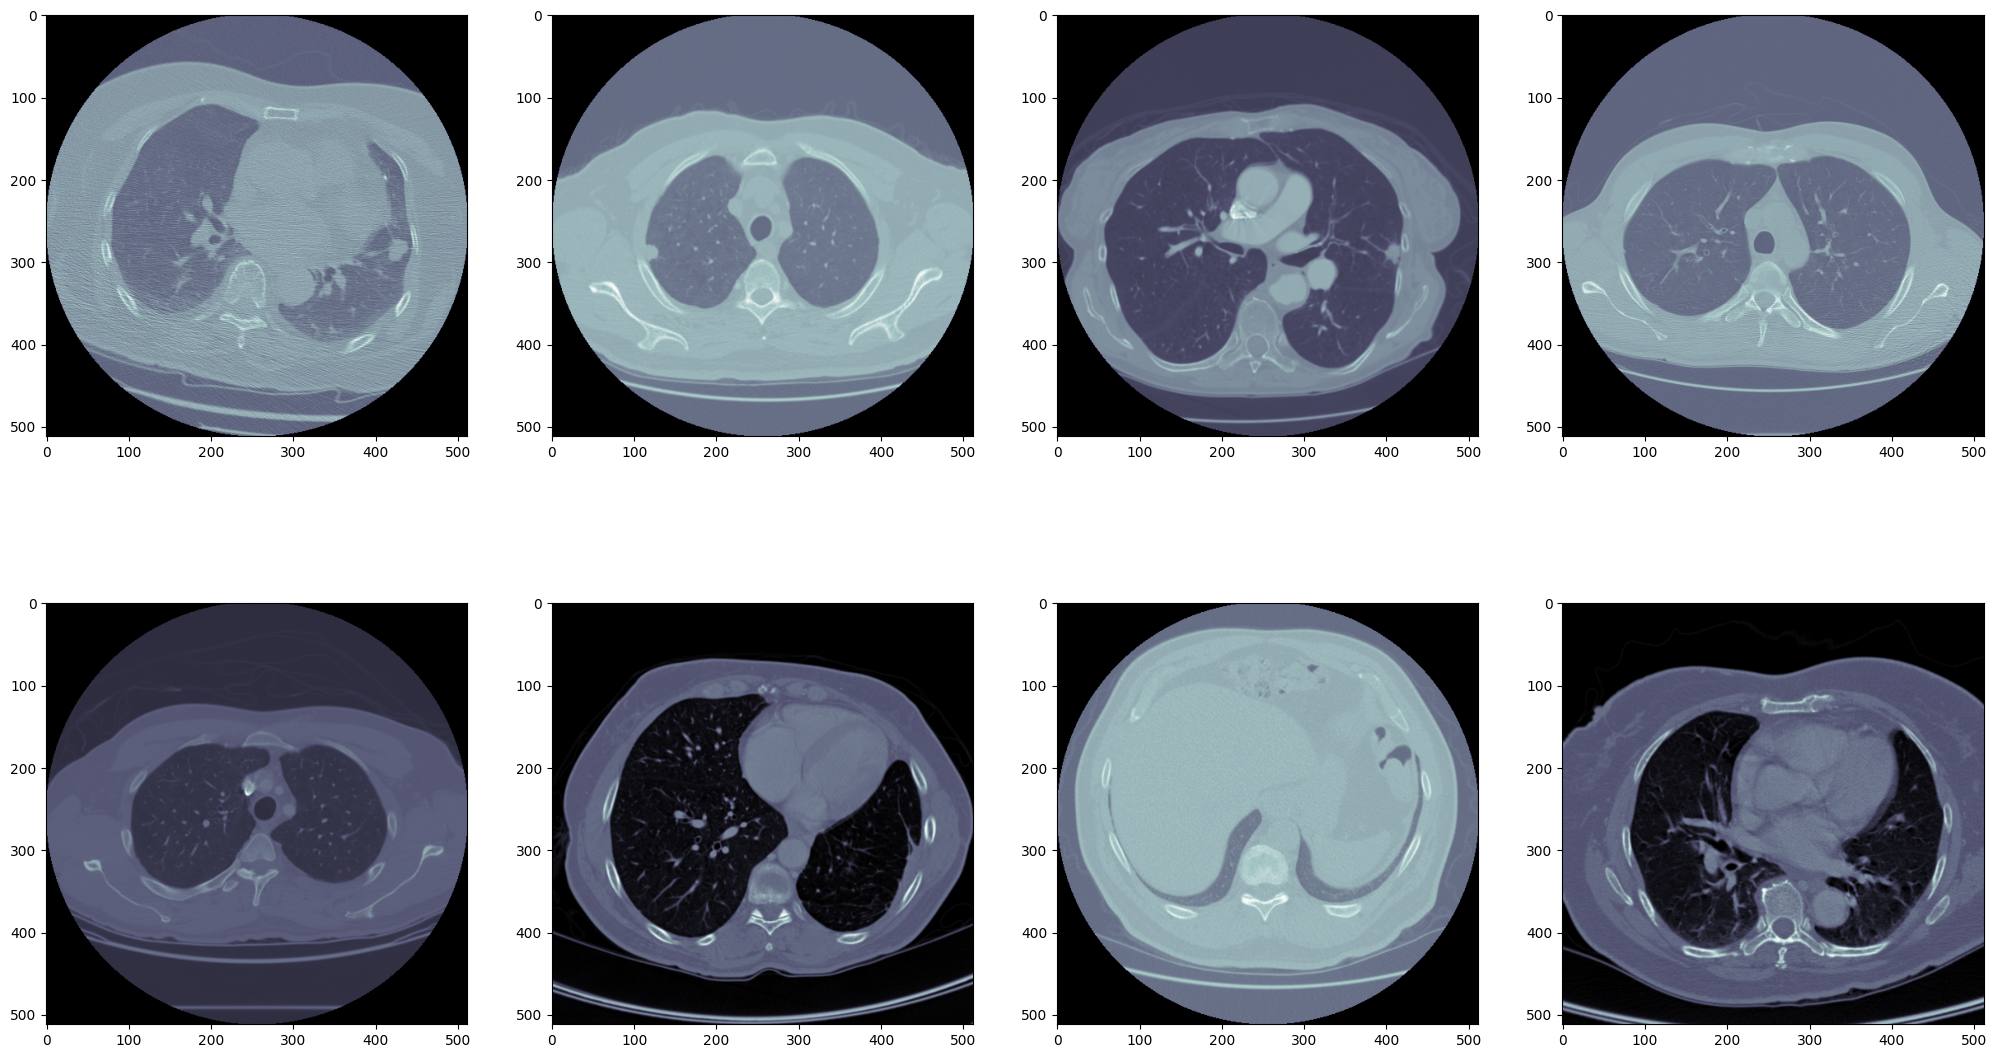

In [46]:
display(norm_imgs)

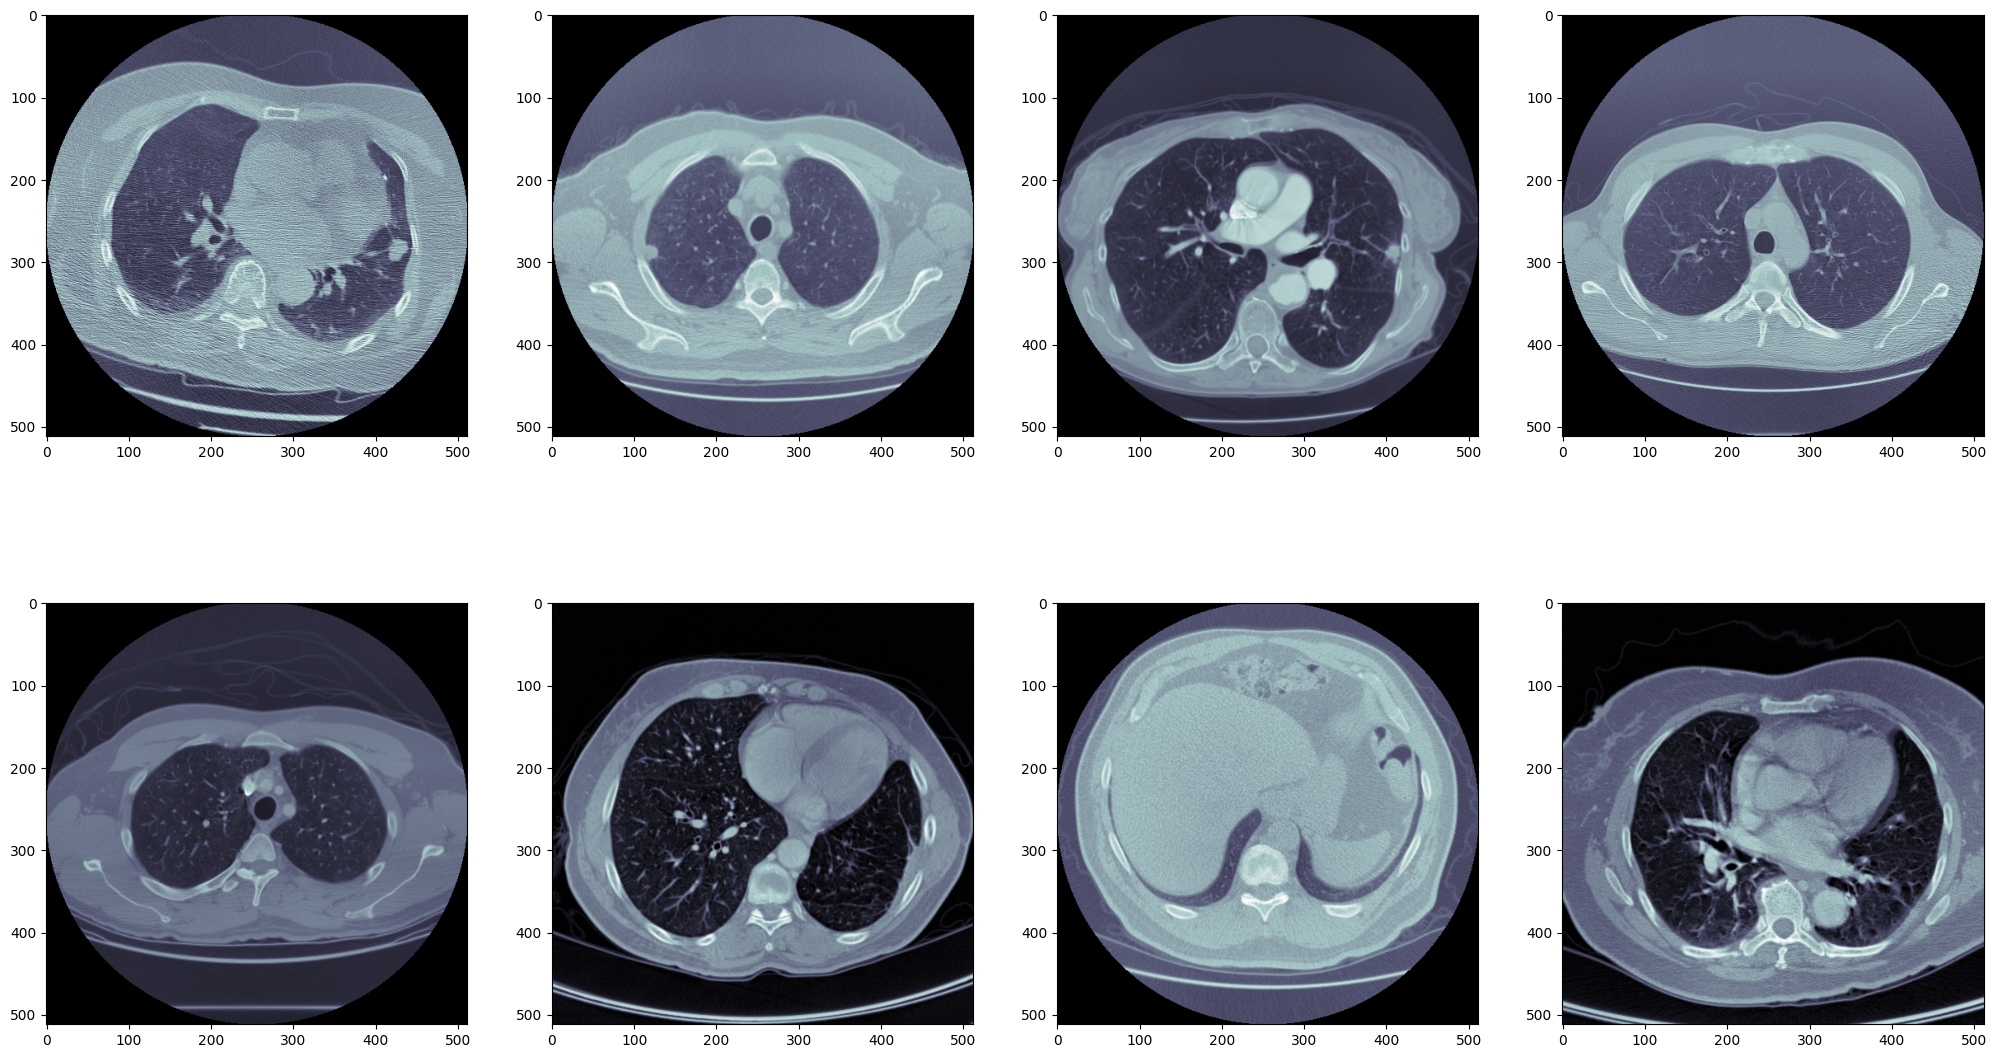

In [47]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
adjusted_norm_imgs = copy.deepcopy(norm_imgs)
for img in adjusted_norm_imgs:
    for i in range(img.shape[0]):
        im = img[i]
        im = clahe.apply(im.astype(np.uint8))
        img[i] = im
display(adjusted_norm_imgs)

This script applies Contrast Limited Adaptive Histogram Equalization (CLAHE) to a list of normalized images (`norm_imgs`). For each image in the list, CLAHE is applied to each slice, enhancing the contrast. The processed images are then displayed using the `display` function.

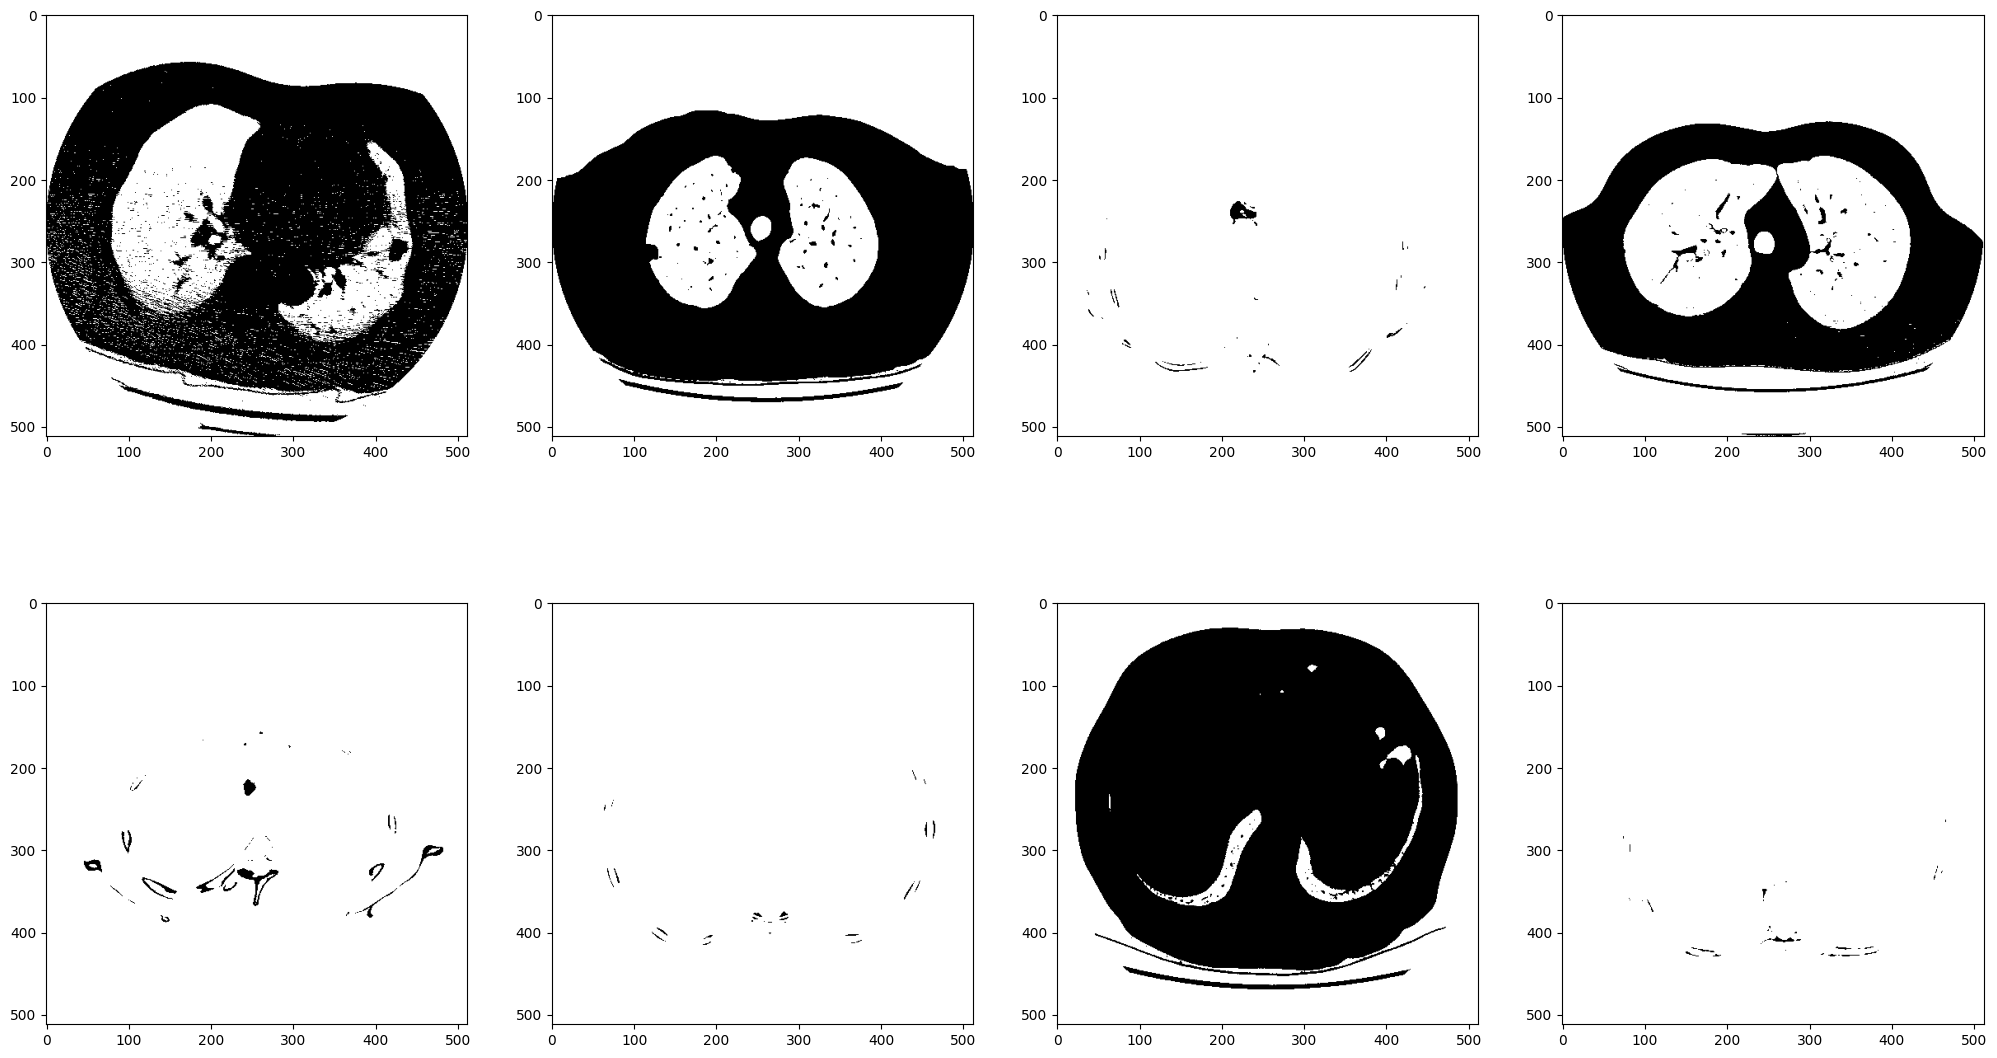

In [48]:
thres = []
for img in norm_imgs:
    ret, t = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    thres.append(t)
display(thres, cmap="gray")

This script applies binary inverse thresholding to each normalized image in the `norm_imgs` list. It thresholds each image with a cutoff value of 127, where pixel values above 127 are set to 0, and those below are set to 255. The thresholded images are then displayed using the `display` function with a grayscale colormap.

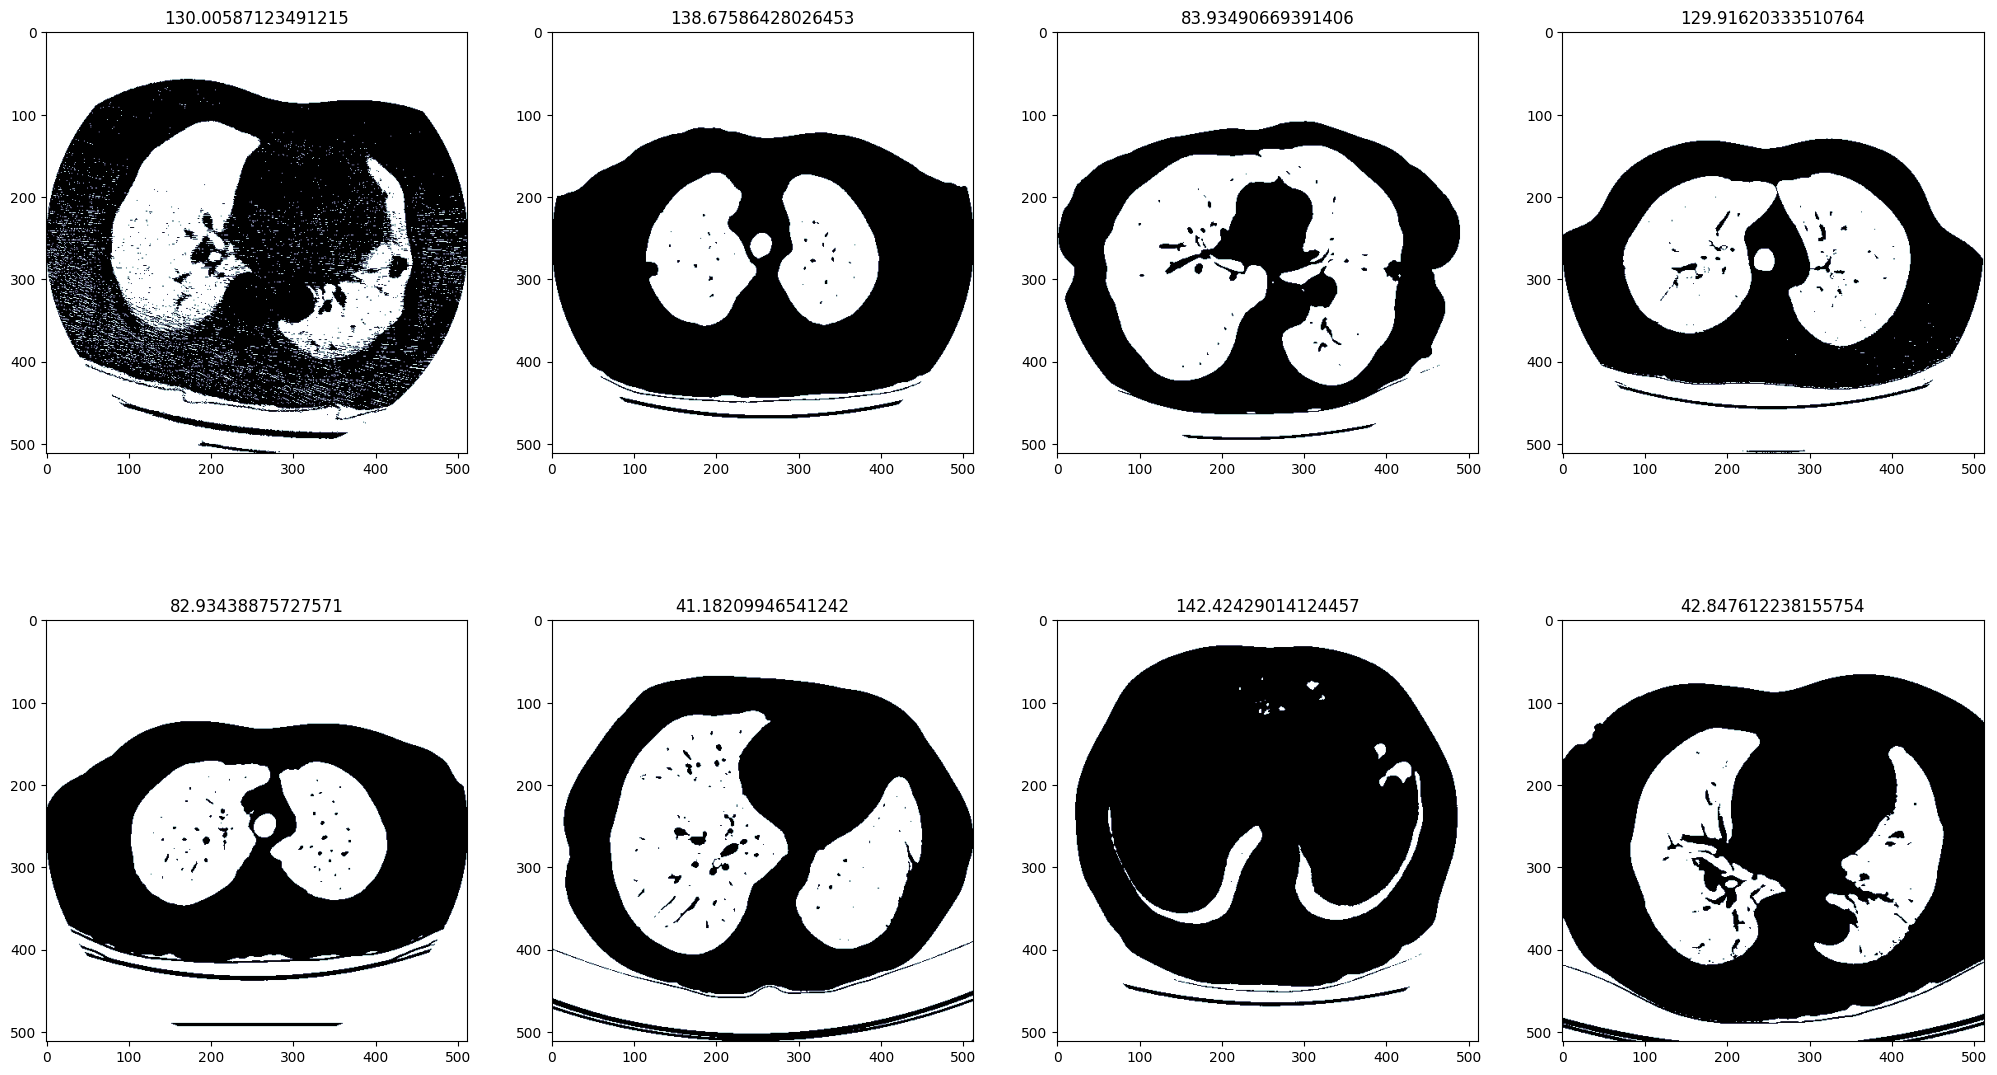

In [49]:
thres2 = []
thres_vals = []
for i,img in enumerate(norm_imgs):
    img = img[layers[i]]
    centeral_area = img[100:400, 100:400]
    kmeans = KMeans(n_clusters=2).fit(np.reshape(centeral_area, [np.prod(centeral_area.shape), 1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    ret, thres_img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY_INV)
    thres2.append(thres_img)
    thres_vals.append(threshold)

display(thres2, titles=thres_vals)

This script applies adaptive thresholding based on k-means clustering to each image in `norm_imgs`. For each image:

1. It selects a central region (`100:400, 100:400`).
2. It performs k-means clustering with 2 clusters on the pixel values of the central area.
3. The average of the cluster centers is calculated and used as the threshold value.
4. The image is thresholded using this value, and the binary inverse result is stored.

The processed images (`thres2`) and their corresponding threshold values (`thres_vals`) are then displayed using the `display` function.

####REMOVING NOISE

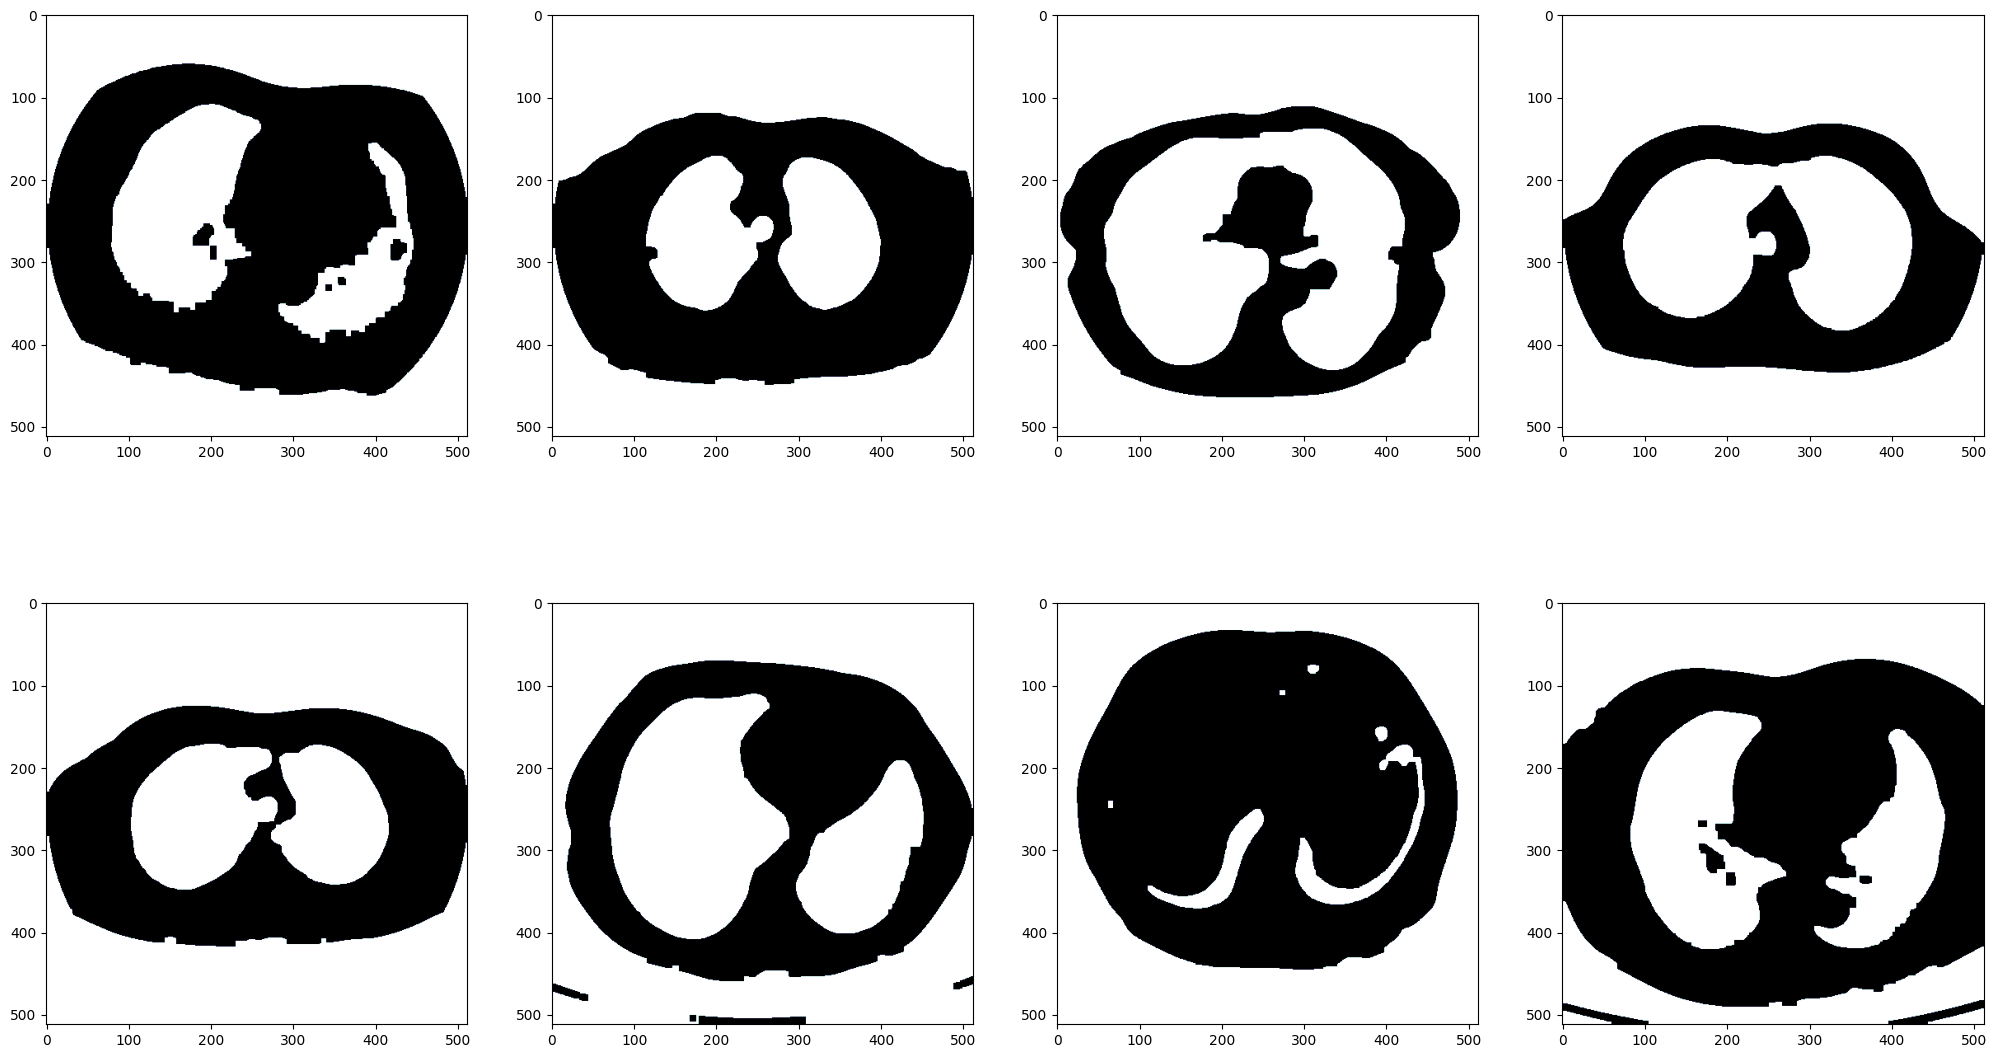

In [ ]:
morphed_imgs = []
for img in thres2:  # Iterate through the thresholded images
    img = cv2.erode(img, kernel=np.ones([4,4])) # Perform erosion with a 4x4 kernel to remove small noise
    img = cv2.dilate(img, kernel=np.ones([13,13])) # Perform dilation with a 13x13 kernel to enlarge the remaining structures
    img = cv2.erode(img, kernel=np.ones([8,8])) # Perform erosion again with an 8x8 kernel to refine the structures
    morphed_imgs.append(img)
    
display(morphed_imgs)

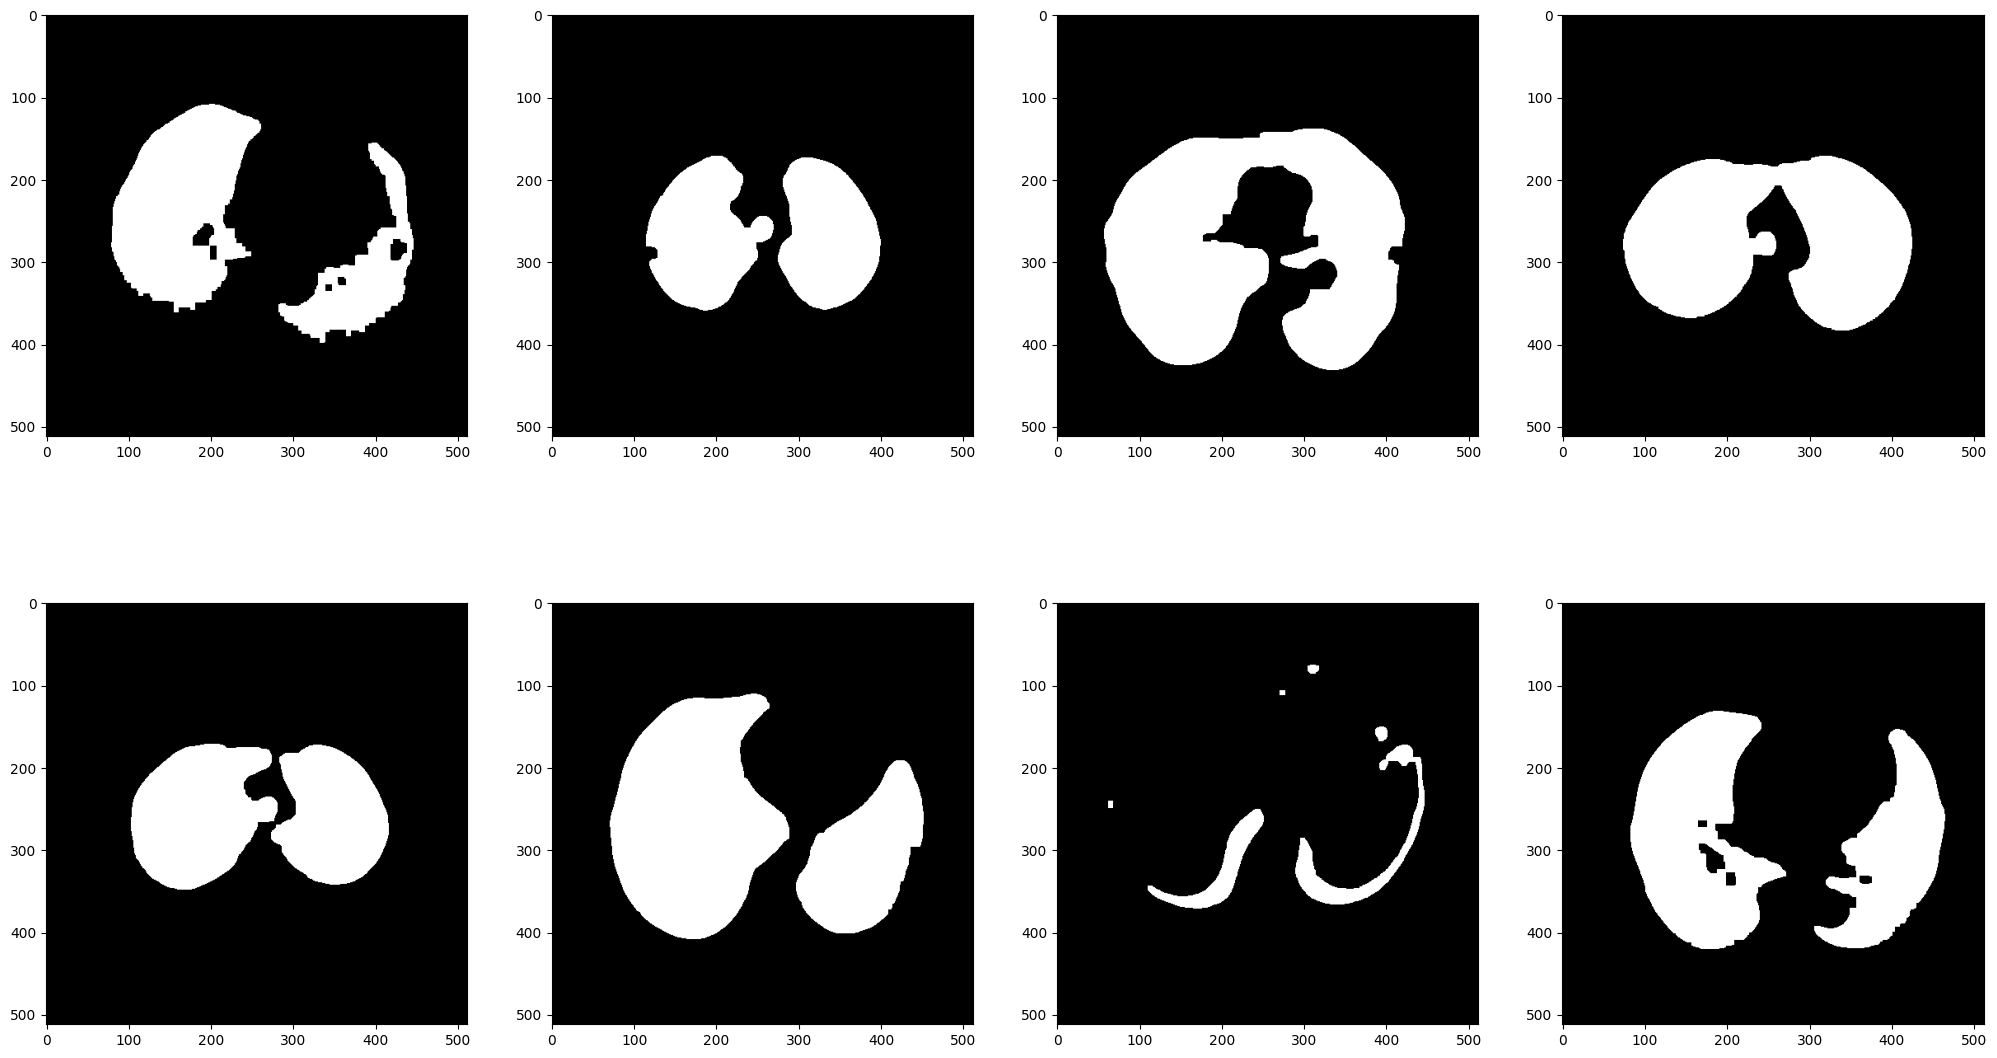

In [ ]:
processed_masks = []
for img in morphed_imgs:
    labels = measure.label(img) # Label connected components in the binary image
    regions = measure.regionprops(labels) # Get properties of the labeled regions (connected components)
    good_labels = [] # List to store labels of regions that meet certain criteria
    for prop in regions:
        B = prop.bbox # Get the bounding box of the region (min_row, min_col, max_row, max_col)
        if B[2]-B[0] < 500 and B[3]-B[1] < 490 and B[0] > 17 and B[2] < 495: # Apply conditions to filter regions based on their bounding box size and position
            good_labels.append(prop.label) # Add label to list if it meets criteria

    mask = np.zeros_like(labels)
    for N in good_labels:
        mask = mask + np.where(labels == N, 1, 0)
    processed_masks.append(mask)

display(processed_masks, cmap="gray")

Filling Internal Holes

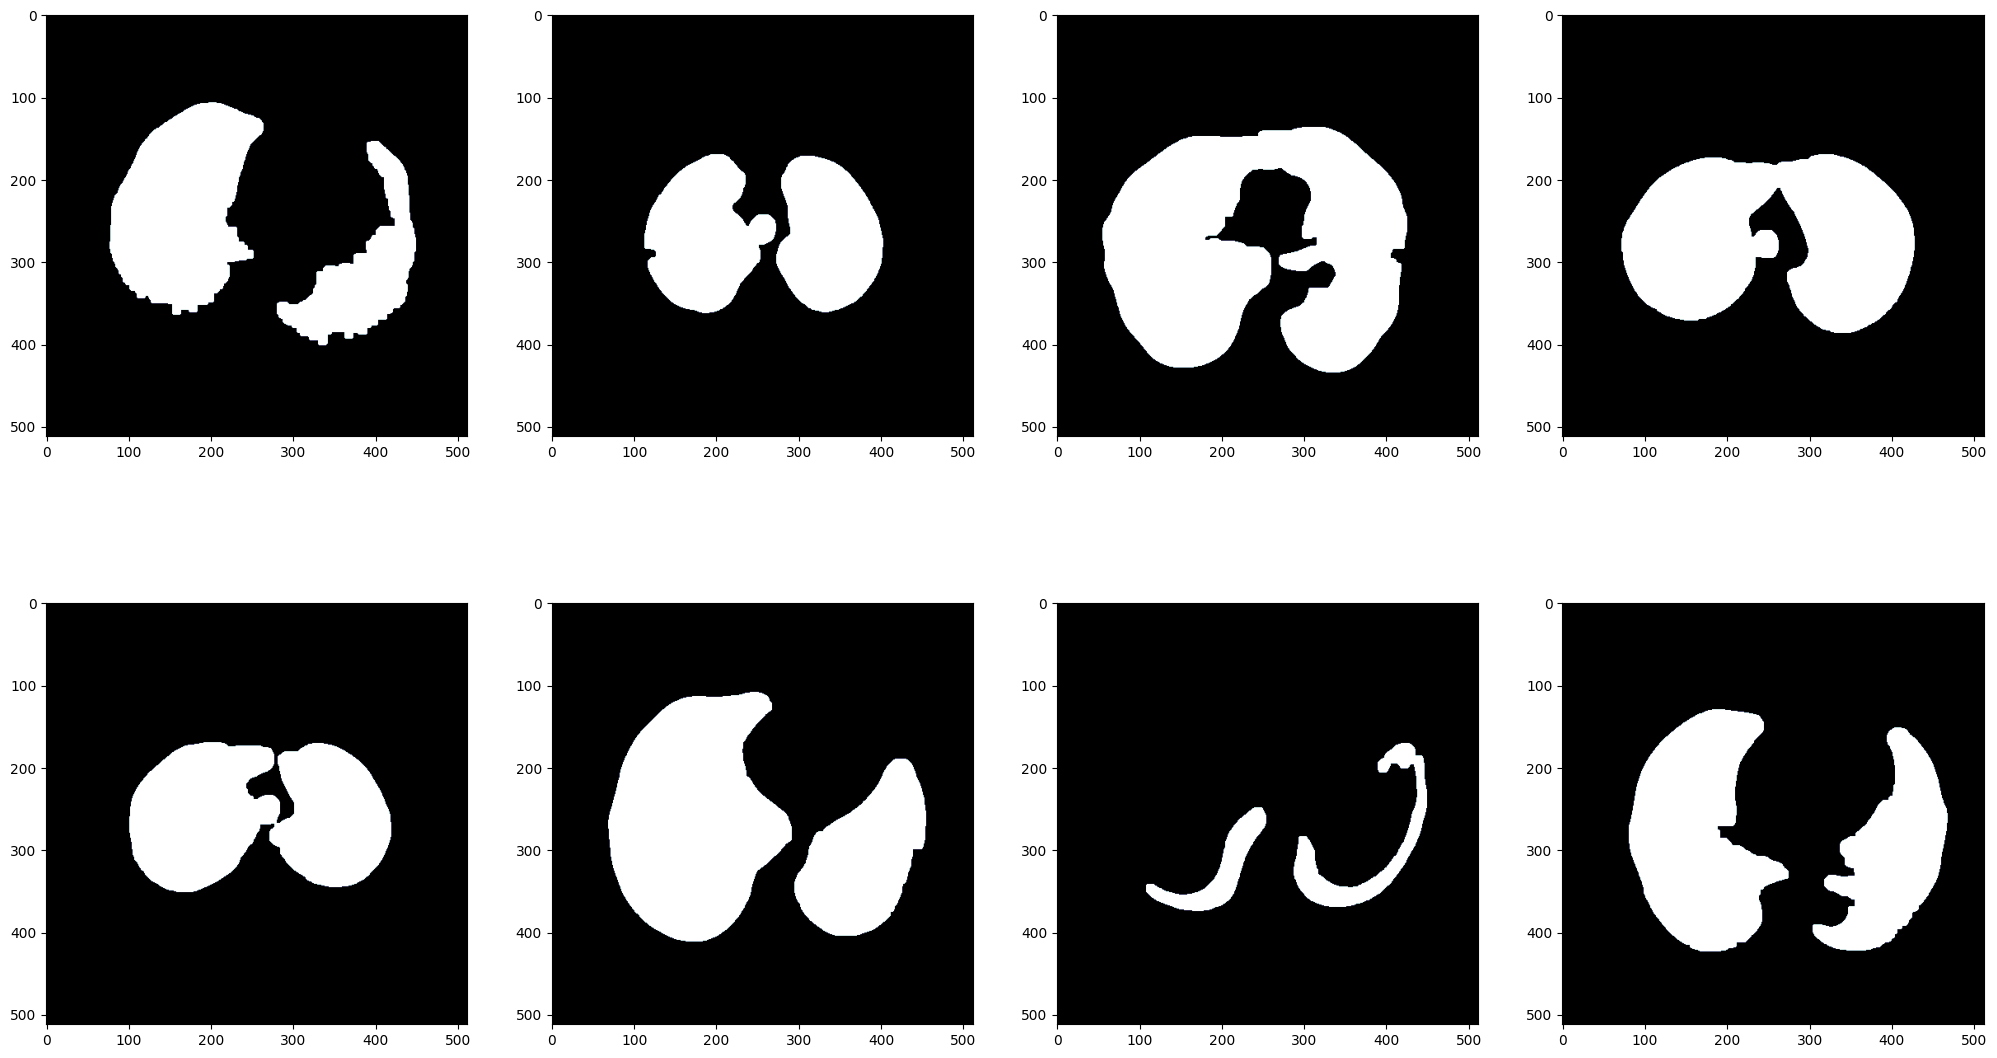

In [ ]:
p_final_masks = []
for im_th in processed_masks:
    contours,hirearchy = cv2.findContours(im_th,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    # Find contours in the binary image (im_th) and retrieve the hierarchy

    internal_contours = np.zeros(im_th.shape)
    external_contours = np.zeros(im_th.shape)
# Initialize empty arrays to store internal and external contours

    for i in range(len(contours)):
        if hirearchy[0][i][3] == -1:  
            # Check if the contour is an external contour (hierarchy value -1 indicates external)

            area = cv2.contourArea(contours[i]) # Calculate the area of the contour
            if area>518.0: # Only keep contours with area greater than 518
                # Draw the external contours onto the external_contours mask (filled with 1)

                cv2.drawContours(external_contours,contours,i,(1,1,1),-1)

    external_contours = img = cv2.dilate(external_contours, kernel=np.ones([4,4]))
     # Append the dilated external contours mask to the list of final masks
    p_final_masks.append(external_contours)
display(p_final_masks)

Including Nodules Attached to Walls

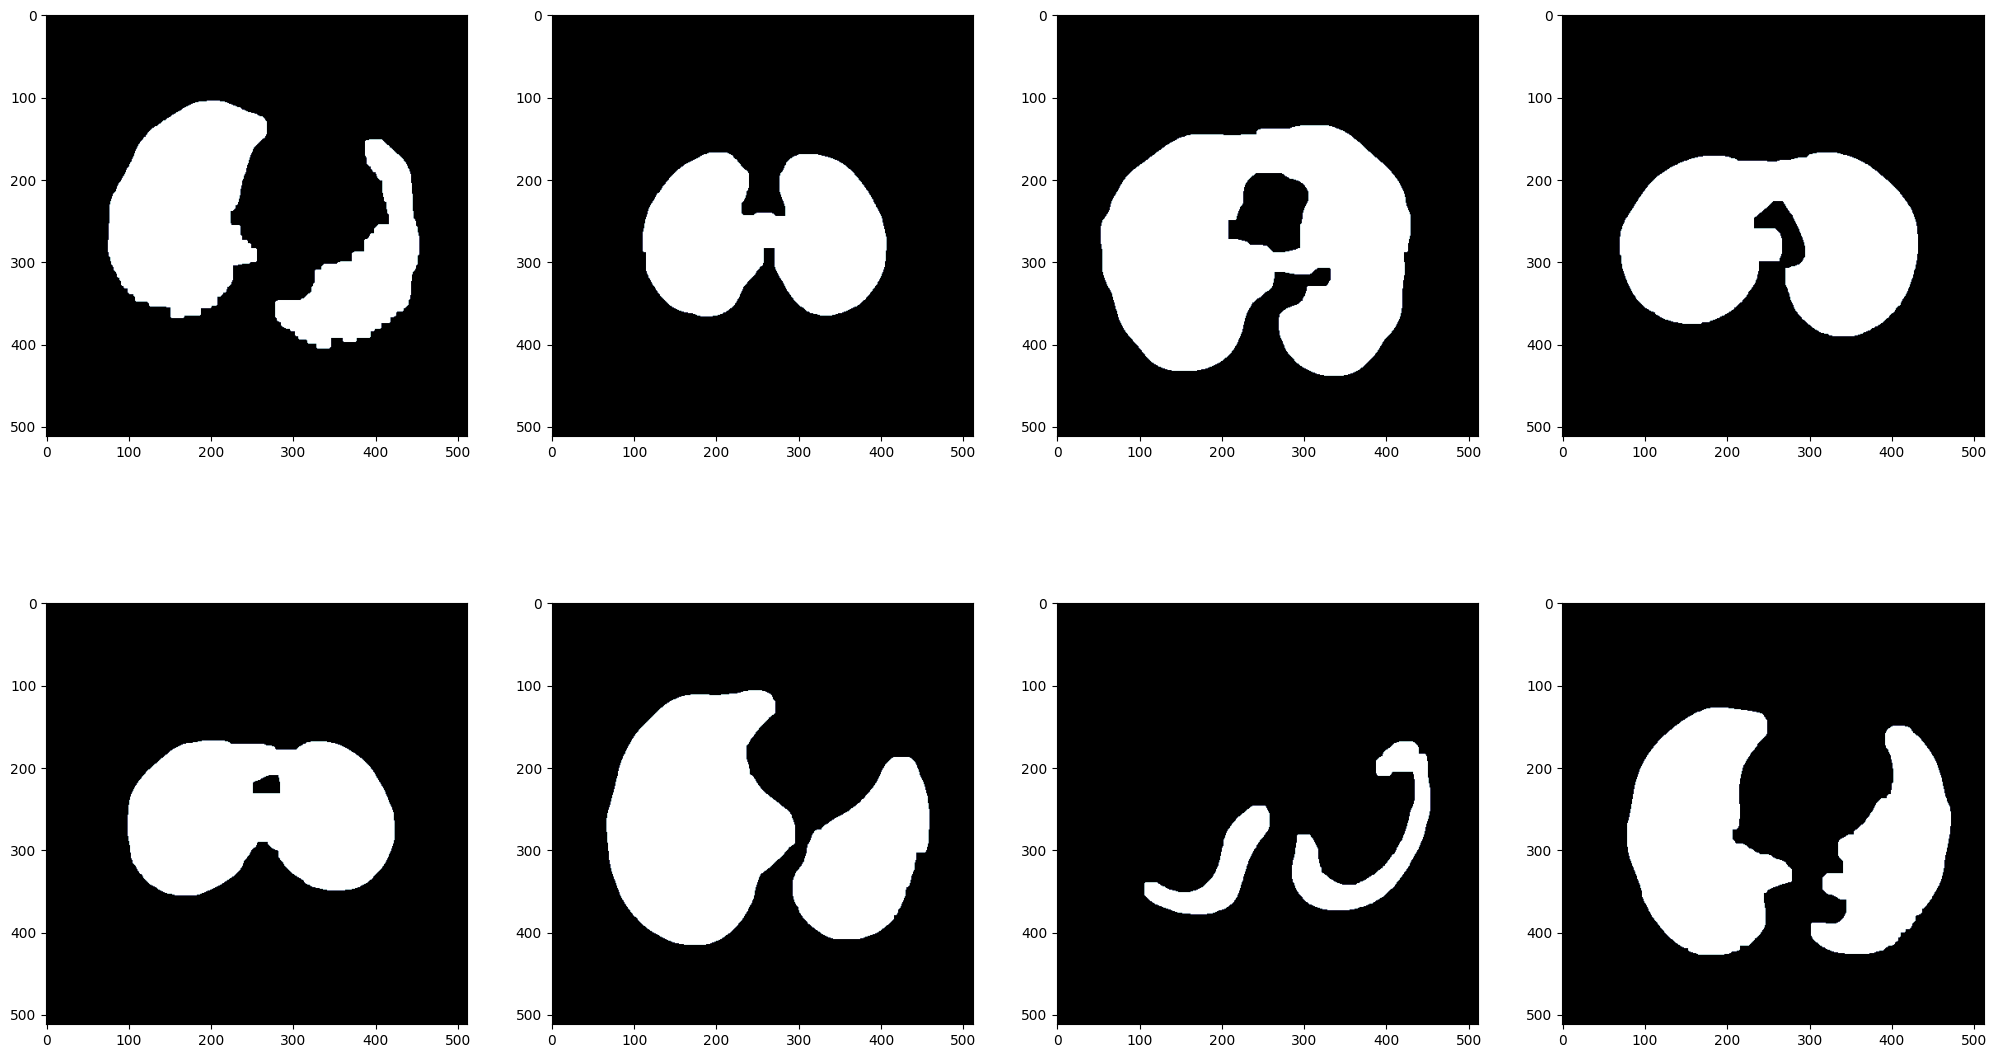

In [ ]:
final_masks = []
for img in p_final_masks:
    img = cv2.bitwise_not(img.astype(np.uint8)) # Invert the binary mask (flip 0s to 255 and 255s to 0s)
    img = cv2.erode(img, kernel=np.ones((7,7)))  # Erode the mask to reduce small white areas (7x7 kernel)
    img = cv2.bitwise_not(img) # Invert the mask back to its original form
    
    img = cv2.dilate(img, kernel=np.ones((12,12))) 
    img = cv2.erode(img, kernel=np.ones((12,12))) 
    final_masks.append(img)
    
display(final_masks)

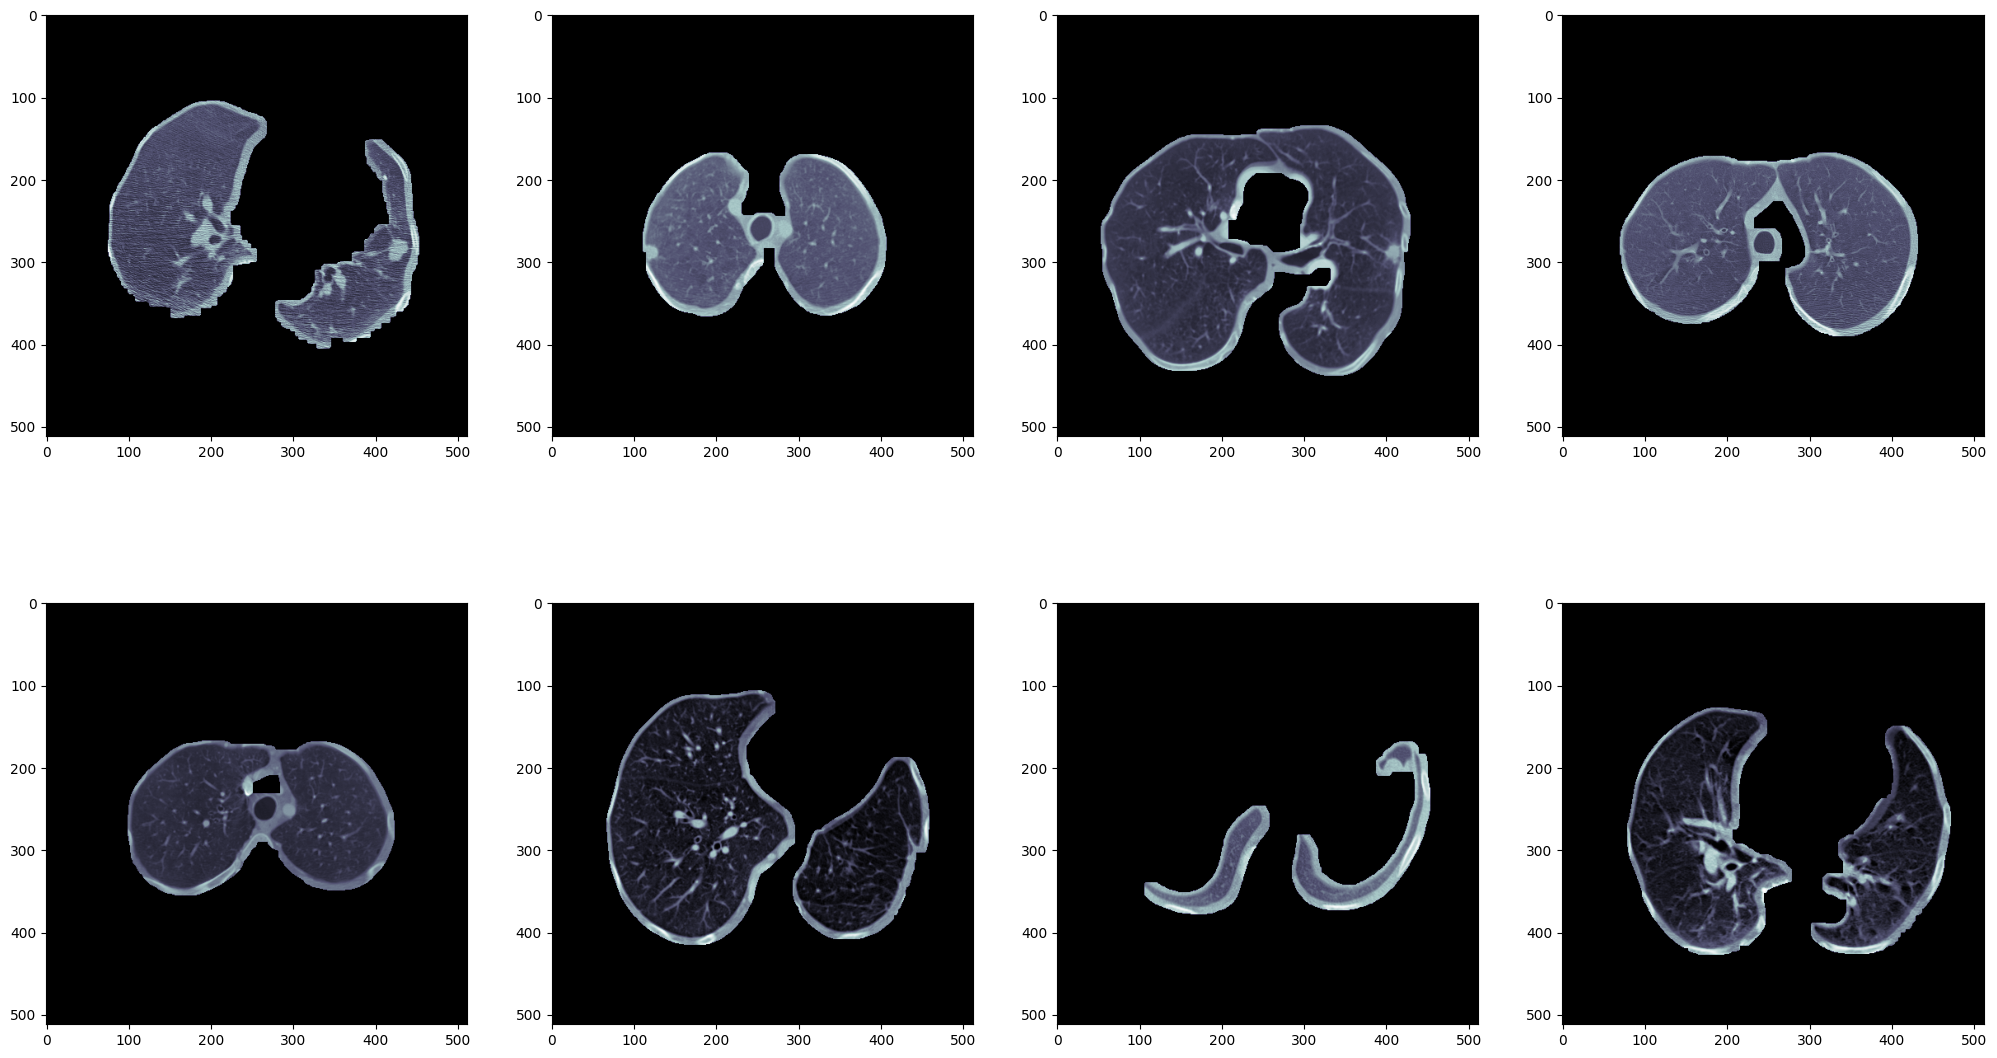

In [54]:
segmented_lungs = []
for i,(img, mask) in enumerate(zip(adjusted_norm_imgs, final_masks)):
    img = img.astype(np.uint8)
    mask = mask.astype(np.uint8)
    seg = cv2.bitwise_and(img[layers[i]], img[layers[i]], mask=mask)
    segmented_lungs.append(seg)

display(segmented_lungs)

This script segments the lung regions from the normalized images using the final binary masks. It applies a bitwise AND operation between each image slice and its corresponding mask to keep only the regions defined by the mask. The segmented lung images are then stored and displayed.